In [ ]:
# upgrade scipy to be able to use qmc
# after that automatically restarts the cell
import os
! pip install scipy --upgrade
os.kill(os.getpid(), 9)

In [22]:
import numpy as np
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import qmc

In [23]:
tf.keras.backend.set_floatx("float64")

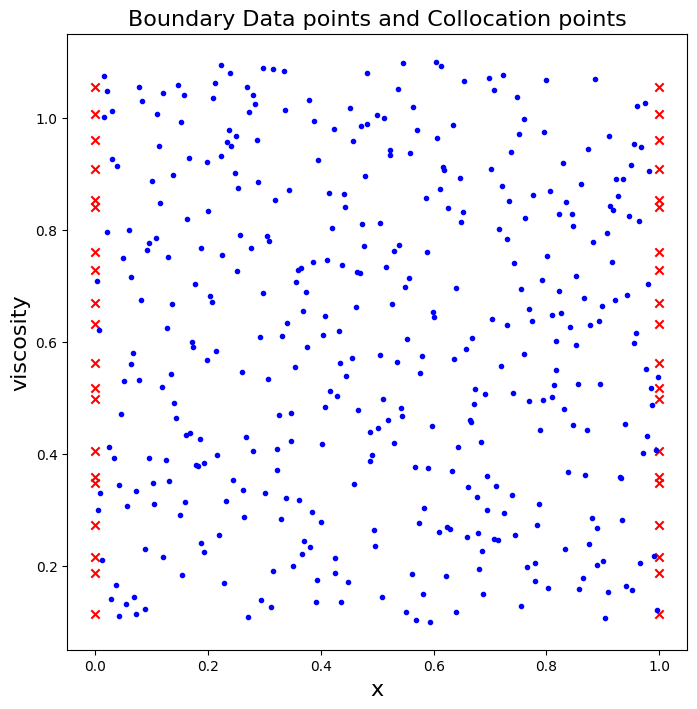

In [24]:
### data generation
n_bc = 2
n_data_per_bc = 20
#
engine = qmc.LatinHypercube(d=1)
data = np.zeros([2 ,n_data_per_bc , 3])


for i, j in zip(range(n_bc), [0, +1, 0, +1]):
    points = (engine.random(n=n_data_per_bc)[:, 0] - 0.) * 1    
    data[i, :, 0] = j
    data[i, :, 1] = points

data[0, :, 1] =  data[i, :, 1] + 0.1
data[1, :, 1] =  data[i, :, 1] + 0.1

# BC Values
# the viscosity ......... is now on y_d (second component)
# Here vary between 0.1 and 1.1 .................
for j in range(0,n_data_per_bc):    
    data[0, j, 2] = 0
    data[1, j, 2] = 0

data = data.reshape(n_data_per_bc * n_bc, 3)
#
x_d, y_d, t_d = map(lambda x: np.expand_dims(x, axis=1), 
                    [data[:, 0], data[:, 1], data[:, 2]])
#
Nc = 400
engine = qmc.LatinHypercube(d=2)
colloc = engine.random(n=Nc)
colloc = 1 * (colloc -0.)
colloc[:, 1] =  colloc[:, 1] + 0.1
#
x_c, y_c = map(lambda x: np.expand_dims(x, axis=1), 
               [colloc[:, 0], colloc[:, 1]])

#
plt.figure("", figsize=(8, 8))
plt.title("Boundary Data points and Collocation points",fontsize=16)

plt.scatter(data[:, 0], data[:, 1], marker="x", c="r", label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1],  marker=".", c="b", label="CP")
plt.xlabel("x",fontsize=16)
plt.ylabel("viscosity",fontsize=16)
plt.show()
#

x_c, y_c, x_d, y_d, t_d =map(lambda x: tf.convert_to_tensor(x,dtype=tf.float64),
                             [x_c, y_c, x_d, y_d, t_d])

In [25]:
### model builder function
def DNN_builder(in_shape=2, out_shape=1, n_hidden_layers=5, 
                neuron_per_layer=60, actfn="tanh"):
    # input layer
    input_layer = tf.keras.layers.Input(shape=(in_shape,))
    # hidden layers
    hidden = [tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)]
    for i in range(n_hidden_layers-1):
        new_layer = tf.keras.layers.Dense(neuron_per_layer,
                                          activation=actfn,
                                          activity_regularizer=None)(hidden[-1])
        hidden.append(new_layer)
    # output layer
    output_layer = tf.keras.layers.Dense(1, activation=None)(hidden[-1])
    # building the model
    name = f"DNN-{n_hidden_layers}"
    model = tf.keras.Model(input_layer, output_layer, name=name)
    return model

In [26]:
tf.keras.backend.clear_session()
model = DNN_builder(2, 1, 5, 60, "tanh")
model.summary()
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, 
                          show_layer_names=True, show_dtype=True, 
                          show_layer_activations=True)

Model: "DNN-5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 60)                180       
                                                                 
 dense_1 (Dense)             (None, 60)                3660      
                                                                 
 dense_2 (Dense)             (None, 60)                3660      
                                                                 
 dense_3 (Dense)             (None, 60)                3660      
                                                                 
 dense_4 (Dense)             (None, 60)                3660      
                                                                 
 dense_5 (Dense)             (None, 1)                 61    

In [27]:
@tf.function
def u(x, y):
    u = model(tf.concat([x, y], axis=1))
    return u

In [28]:
@tf.function
def f(x, y):
    u0 = u(x, y)
    u_x = tf.gradients(u0, x)[0]
    #u_y = tf.gradients(u0, y)[0]
    u_xx = tf.gradients(u_x, x)[0]
       
    F = u_x - y*(u_xx) - 1
    
    return tf.reduce_mean(tf.square(F))

In [29]:
@tf.function
def mse(y, y_):
    return tf.reduce_mean(tf.square(y-y_))

@tf.function
def msex(y, y_):
    # MSE only for boundaries at x = -/+ 1 .....
    yr = tf.reshape(y,[4, n_data_per_bc])
    yr_= tf.reshape(y_,[4, n_data_per_bc])
    yrr = yr[0:2,:]
    yrr_= yr_[0:2,:]
    retour = tf.reduce_mean(tf.square(yrr-yrr_))    
    return retour

@tf.function
def msey(y, y_):
    # MSE only for boundaries at y = -/+ 1 .......
    yr = tf.reshape(y,[4, n_data_per_bc])
    yr_= tf.reshape(y_,[4, n_data_per_bc])
    yrr = yr[2:4,:]
    yrr_= yr_[2:4,:]
    retour = tf.reduce_mean(tf.square(yrr-yrr_))    
    return retour

    0, 1.38125693
  200, 0.13024084
  400, 0.10849817
  600, 0.05744464
  800, 0.03243696
 1000, 0.02005231
 1200, 0.01036702
 1400, 0.00477788
 1600, 0.00120971
 1800, 0.00048997
 2000, 0.00028664
 2200, 0.00018114
 2400, 0.00011788
 2600, 0.00008179
 2800, 0.00006154
 3000, 0.00006754
 3200, 0.00004382
 3400, 0.00003722
 3600, 0.00005192
 3800, 0.00003158
 4000, 0.00004625
 4200, 0.00002810
 4400, 0.00003693
 4600, 0.00002574
 4800, 0.00002425
 5000, 0.00004207
 5200, 0.00004260
 5400, 0.00002136
 5600, 0.00019609
 5800, 0.00003505
 6000, 0.00001906
 6200, 0.00001842
 6400, 0.00001776
 6600, 0.00009574
 6800, 0.00002176
 7000, 0.00001667
 7200, 0.00001572
 7400, 0.00001515
 7600, 0.00001468
 7800, 0.00001433
 8000, 0.00001387
 8200, 0.00001396
 8400, 0.00001343
 8600, 0.00001275
 8800, 0.00001451
 9000, 0.00001325
 9200, 0.00001252
 9400, 0.00001147
 9600, 0.00001140
 9800, 0.00001274
10000, 0.00001063
10200, 0.00001040
10400, 0.00001135
10600, 0.00001011
10800, 0.00000964
11000, 0.0

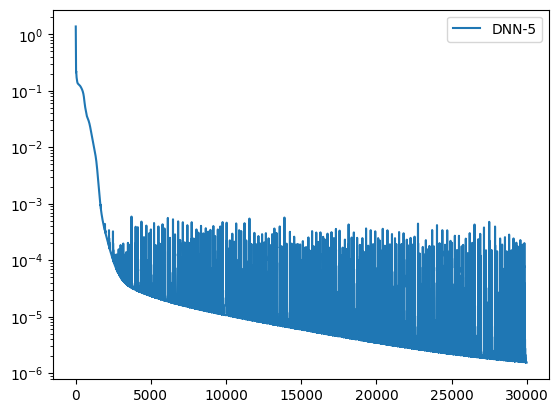

In [30]:
loss = 0
epochs = 30000
opt = tf.keras.optimizers.legacy.Adam(learning_rate=2e-4)
epoch = 0
loss_values = np.array([])
#
start = time.time()
#
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        T_ = u(x_d, y_d)
        L = f(x_c, y_c)
        # The MSE is applied only on t_d ...
        l = mse(t_d, T_)
        loss = l+ L
    g = tape.gradient(loss, model.trainable_weights)
    opt.apply_gradients(zip(g, model.trainable_weights))
    loss_values = np.append(loss_values, loss)
    if epoch % 200 == 0 or epoch == epochs-1:
        print(f"{epoch:5}, {loss.numpy():.8f}")

#
end = time.time()
computation_time = {}
computation_time["pinn"] = end - start
print(f"\ncomputation time: {end-start:.3f}\n")
#
plt.semilogy(loss_values, label=model.name)
plt.legend()

In [31]:
n = 100
l = 1.
r = 2*l/(n+1)
T = np.zeros([n*n, n*n])
TT = np.zeros([n, n])


bc = {
    "x=-l": 75.,
    "x=+l": 0.,
    "y=-l": 0.,
    "y=+l": 50.
}

/var/folders/55/gkf2h_5j4jjgph1cs8cvzd940000gn/T/ipykernel_3979/3002833875.py:46: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


(-0.005050505050505051,
 1.0050505050505054,
 0.09494949494949495,
 1.1050505050505053)

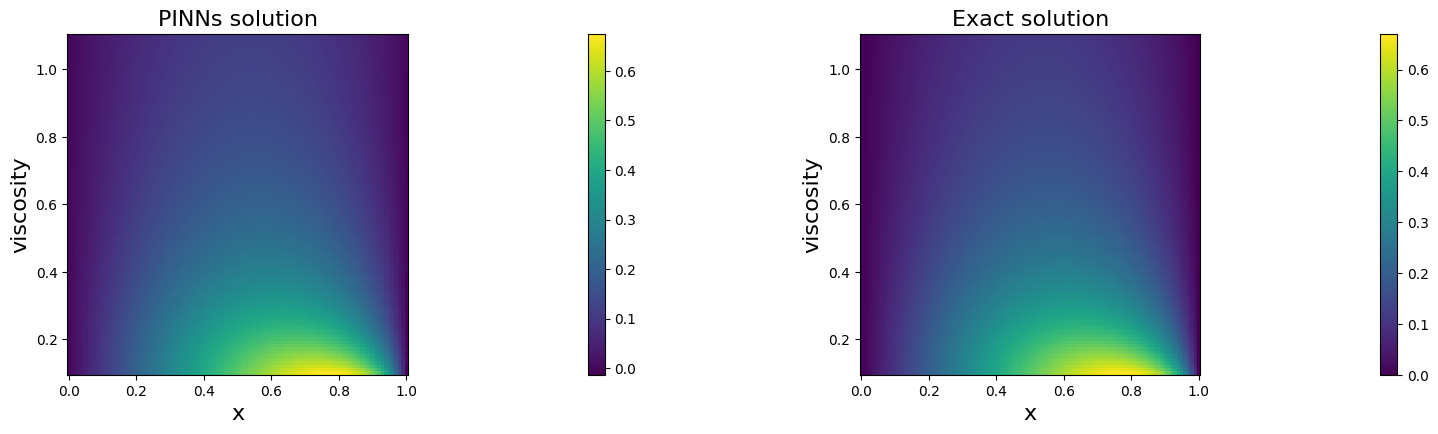

In [32]:
### plotting
plt.figure("", figsize=(16, 8))
#
X = np.linspace(0, +1, n)
Y = np.linspace(0.1, 1.1, n)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)
S = u(X_T, Y_T)
S = S.numpy().reshape(n, n)
#
plt.subplot(221)
plt.pcolormesh(X0, Y0, 1.*S, cmap="viridis")
#plt.colorbar(pad=-0.25)
#plt.contour(x, y, S,14,linewidths=1.95)

plt.colorbar()
plt.xlabel("x",fontsize=16)
plt.ylabel("viscosity",fontsize=16)
plt.title("PINNs solution",fontsize=16)
plt.tight_layout()
plt.axis("square")
#
x = np.linspace(0, +1, n)
y = np.linspace(0.1, 1.1, n)
x, y = np.meshgrid(x, y)


# true solution and error ....

T = x - (np.exp((x-1)/y) - np.exp(-1/y))/(1 - np.exp(-1/y))
TT = T -S

#
plt.subplot(222)
plt.pcolormesh(x, y, T, cmap="viridis")
plt.colorbar()
#plt.contour(x, y, T,14,linewidths=1.95)
plt.title(r"Exact solution",fontsize=16)
plt.xlabel("x",fontsize=16)
plt.ylabel("viscosity",fontsize=16)
plt.xlim(0, +1)
plt.ylim(0., 1)
plt.tight_layout()
plt.axis("square")
#plt.savefig("heat01.png")
#



[5, 19, 39, 89]


/var/folders/55/gkf2h_5j4jjgph1cs8cvzd940000gn/T/ipykernel_3979/1598054178.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


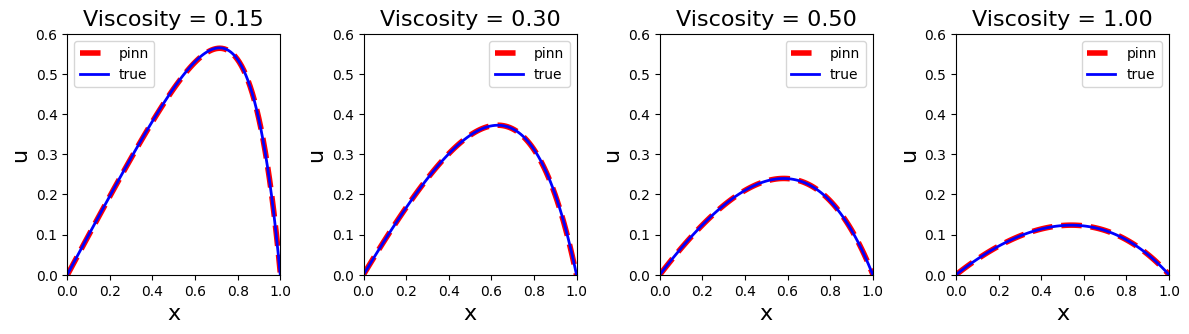

In [33]:
# T...................
n=100
X = np.linspace(0, +1, n)
Y = np.linspace(0.1, +1.1, n)
X0, Y0 = np.meshgrid(X, Y)

X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)

Scomp = u(X_T, Y_T)

S = Scomp[:,0:1]
S = S.numpy().reshape(n, n)
S_ = S.reshape([n, n])

# True B_y .................

T_ = X0 - (np.exp((X0-1)/Y0) - np.exp(-1/Y0))/(1 - np.exp(-1/Y0))


height = 3
frames_val = np.array([0.15, +.3, +.5, 1.])
frames = [*map(int, (frames_val + 1)/2 * (n-1))]

frames = [5, 19, 39, 89]
print(frames)


fig = plt.figure("", figsize=(len(frames)*height, 2*height))

for i, var_index in enumerate(frames):
    plt.subplot(2, len(frames), i+1)
    plt.title(f"Viscosity = {frames_val[i]:.2f}",fontsize=16)
    plt.plot(X0[var_index, :], S_[var_index,:], "r--", lw=4., label="pinn")
    plt.plot(X0[var_index, :], T_[var_index,:], "b", lw=2., label="true")
    plt.ylim(0, 0.6)
    plt.xlim(0, 1.)
    plt.xlabel("x",fontsize=16)
    plt.ylabel("u",fontsize=16)
    plt.tight_layout()
    plt.legend()



